In [147]:
import pickle
import networkx as nx
import pandas as pd
import urllib
import ast
import collections
# z = pickle.load(open('./string_alignment.pkl', 'rb'))
from urllib.parse import urlparse

entity_collection = []
entity_to_mentioner = {}
prefixes = ['california', 'florida', 'illinois', 'ohio', 'newyork', 'nytimes_foxnews', 'texas',]
df_len = {}
for prefix in prefixes:
    df = pd.read_csv('/data_users1/asmithh/trans-fer-entropy/extra_analyses/kw_filtered_ner_' + prefix + '_article_texts_and_info_dedup.csv', sep='\t')
    df_len[prefix] = len(df)
    for media_name, entities in zip(df['media_name'], df['entities']):
        entities = ast.literal_eval(entities)
        idx = -1
        whole_entity = ''
        for e in entities:
            e['word'] = e['word'].replace('#', '')
            if idx + 1 == e['index']:
                whole_entity += e['word']
            else:
                entity_collection.append(whole_entity)
                if whole_entity in entity_to_mentioner:
                    entity_to_mentioner[whole_entity].append(prefix)
                else:
                    entity_to_mentioner[whole_entity] = [prefix]
                whole_entity = e['word']
            idx = e['index']

In [145]:
entity_to_mentioner_count = {k: collections.Counter(v) for k, v in entity_to_mentioner.items()}    

In [157]:
from scipy import stats
import numpy as np
G = nx.Graph()
tups = []
nl = np.array([df_len[p] for p in prefixes]) / sum([v for v in df_len.values()])
for entity, mentions in entity_to_mentioner_count.items():
    if sum([m for m in mentions.values()]) > 50:
        c1 = np.array([mentions[p] for p in prefixes]) / sum([mentions[p] for p in prefixes])
        chi = stats.chisquare(nl, c1)
        if chi.pvalue < 0.05:
            tups.append((chi.pvalue, c1, entity))
        G.add_edges_from([(entity + '_', mentioner[0], {'weight': ct}) for mentioner, ct in mentions.items()])
        G.nodes[entity + '_']['bipartite'] = 0
        for mentioner in mentions.keys():
            G.nodes[mentioner[0]]['bipartite'] = 1

IndexError: list index out of range

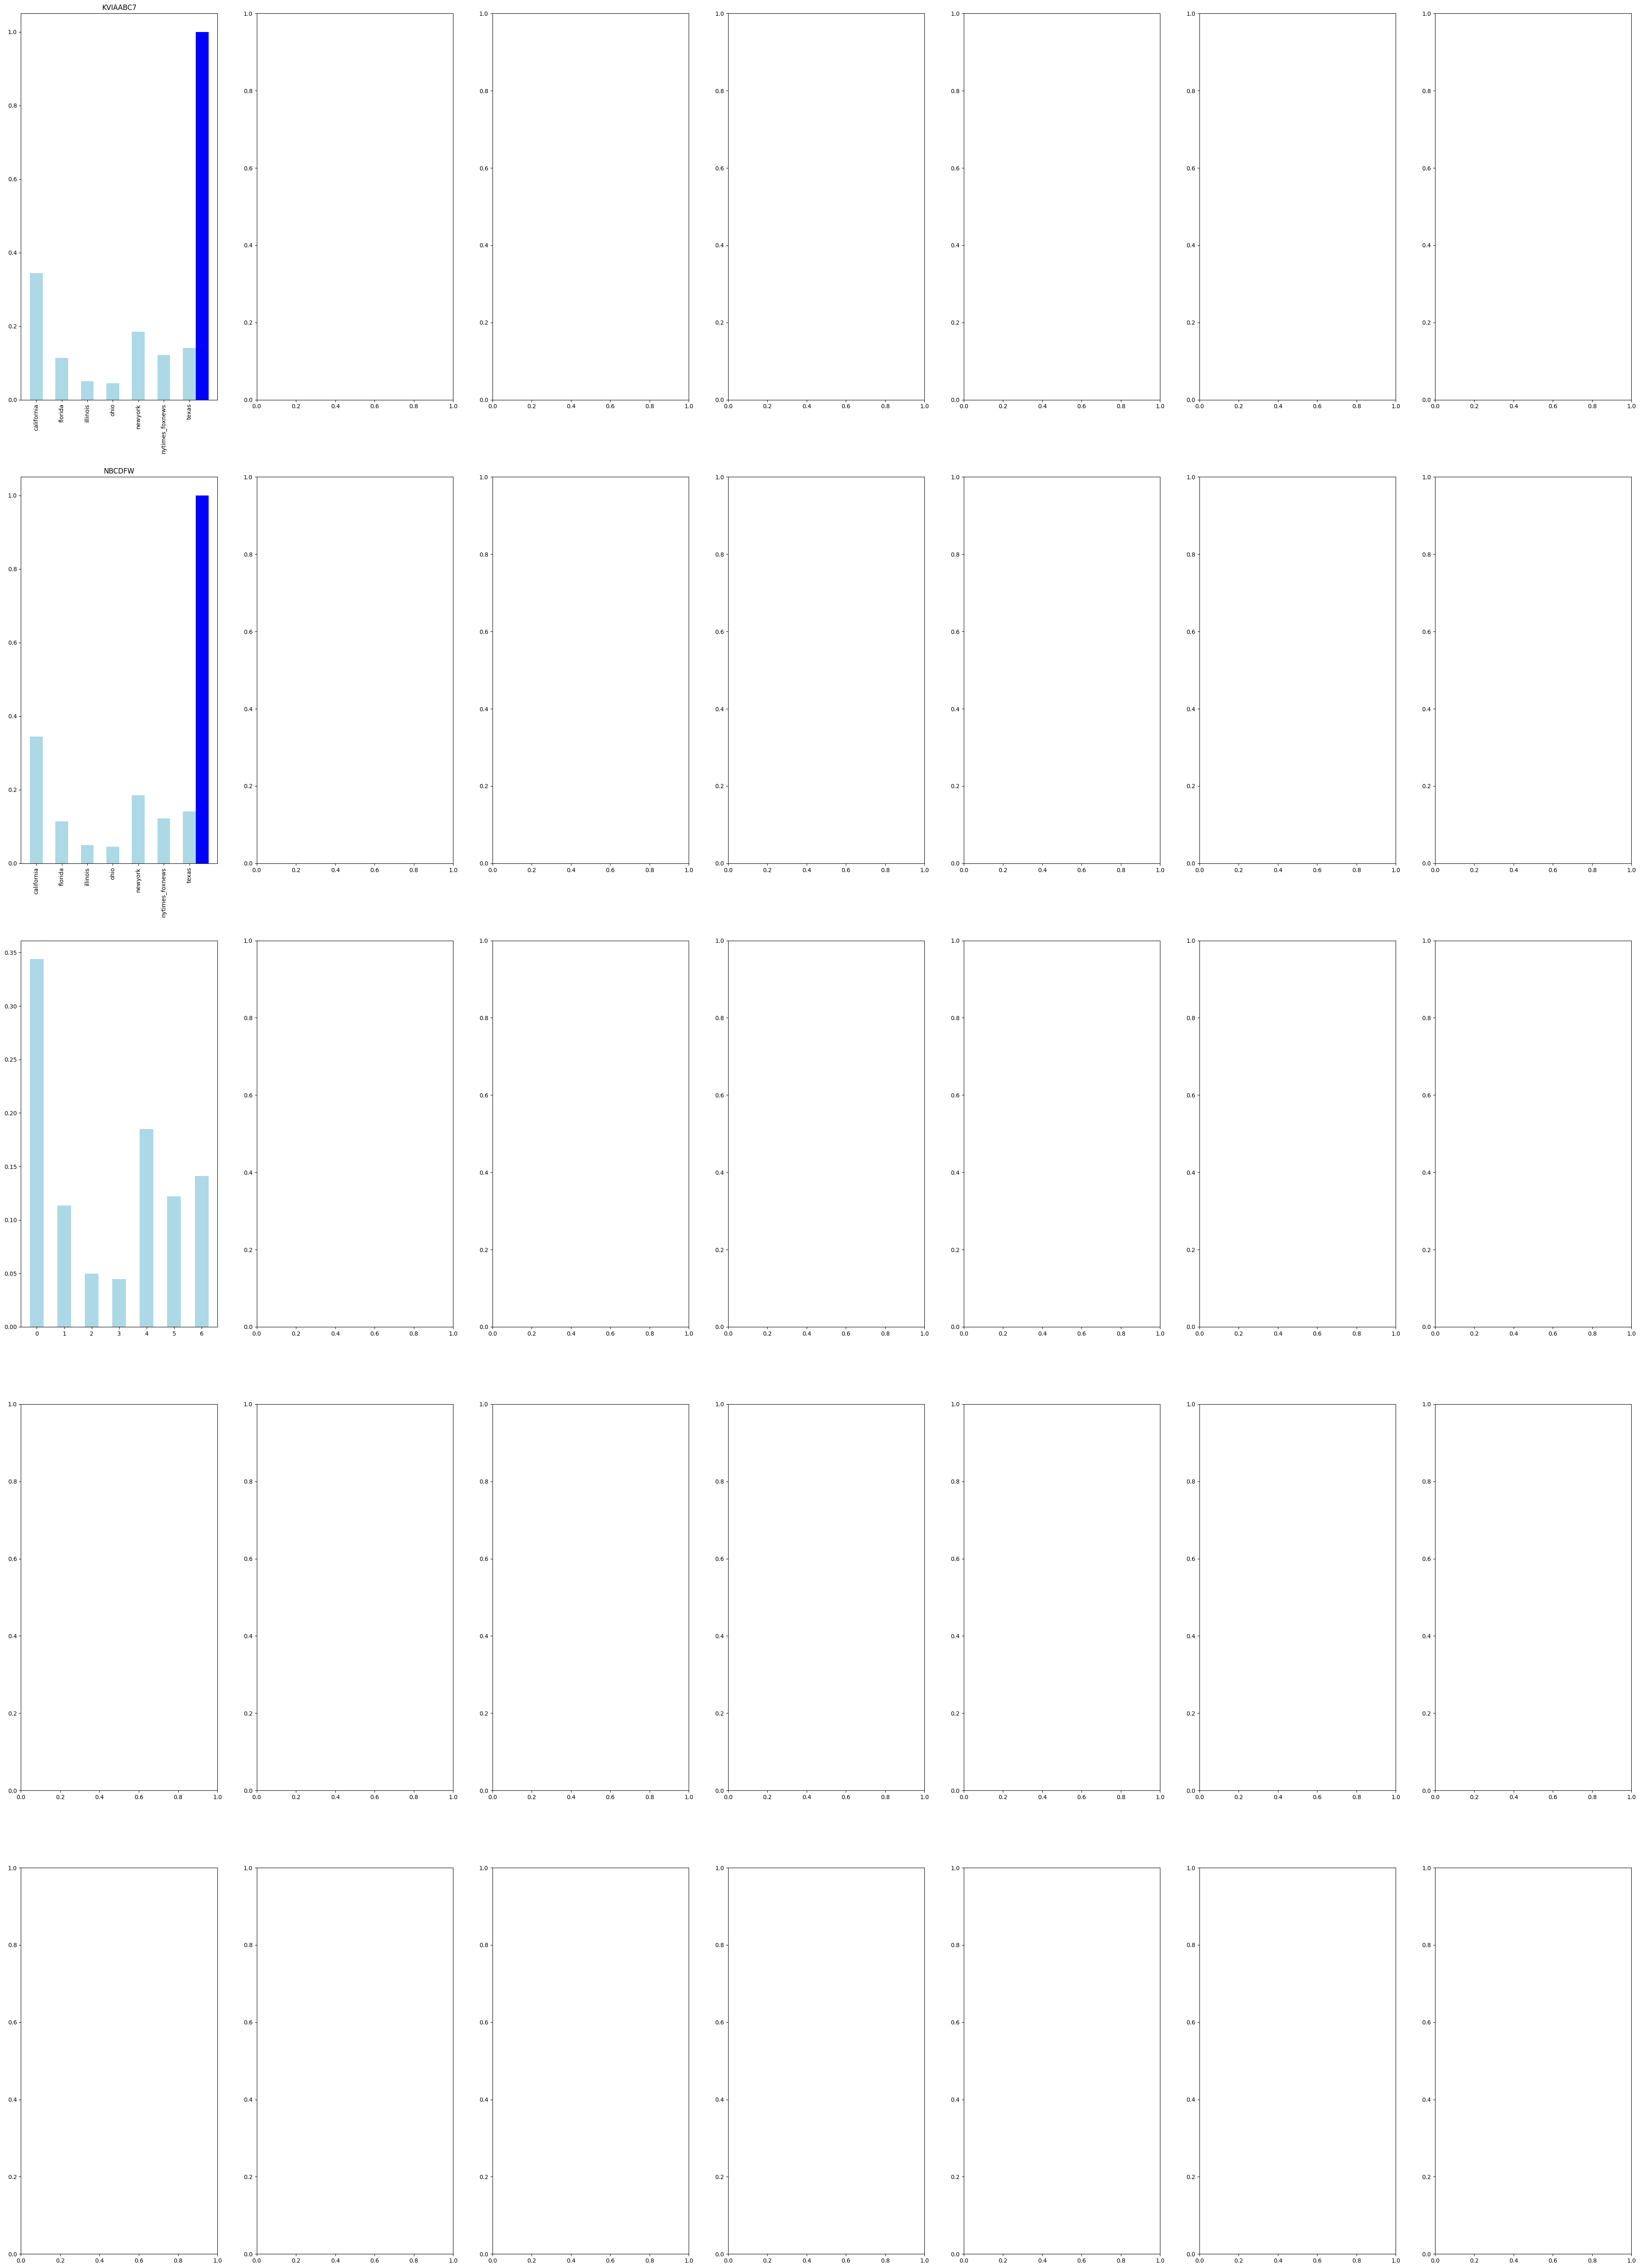

In [181]:
idx = 349
plt.rcParams["figure.figsize"] = (50, 70)
fig, ax = plt.subplots(5, 7)
for i in range(0, 35):
    ax[i % 5, int(i / 5)].bar([y for y in range(7)], nl, color='lightblue', label='article dist', width=0.5)
    ax[i % 5, int(i / 5)].bar([y + 0.5 for y in range(7)], tups[idx + i][1], color='blue', label='mention dist', width=0.5)
    ax[i % 5, int(i / 5)].set_title(tups[idx + i][-1])
    ax[i % 5, int(i / 5)].set_xticks([y for y in range(7)], prefixes, rotation=90)
fig.savefig('{}_bar_plots.svg'.format(str(idx)))

In [64]:
nx.write_gexf(G, 'bipartite_entity_mentioner_10_total_mentions.gexf')

In [126]:
from networkx.algorithms import bipartite
co_mentioned = bipartite.projected_graph(G, [node for node in G.nodes if G.nodes[node]['bipartite'] == 0], )
co_mentioners = bipartite.projected_graph(G, [node for node in G.nodes if G.nodes[node]['bipartite'] == 1], )

In [127]:
communities_mentioners = nx.community.louvain_communities(co_mentioners, resolution=1.0008)

In [128]:
for comm in communities_mentioners:
    print([node for node in comm])

['decaturtribune.com', 'keyt.com', 'nydailyrecord.com', 'norwoodnews.org', 'sanmarcosrecord.com', 'wkbn.com', 'inweekly.net', 'wordpress.com', 'riverjournalonline.com', 'caribbeannationalweekly.com', 'dailypundit.com', 'pleasantonweekly.com', 'jewishpress.com', 'chronicleillinois.com', 'nbcdfw.com', 'skidmorenews.com', 'myhighplains.com', 'cypresscollege.edu', 'dallasnews.com', 'kron4.com', 'danapointtimes.com', 'wfla.com', 'thesouthern.com', 'prospect.org', 'kpbs.org', 'northbaybusinessjournal.com', 'marketbeat.com', 'eltecolote.org', 'lbbusinessjournal.com', 'newstalk1290.com', 'woub.org', 'eaglenewsonline.com', 'tccd.edu', 'fox4news.com', 'wmay.com', 'ibjonline.com', 'wjbc.com', 'news10.com', 'breezecourier.com', 'dallasobserver.com', 'theithacan.org', 'evanstonroundtable.com', 'wjct.org', 'dailynorthwestern.com', 'wpbf.com', 'forestparkreview.com', 'chicagotribune.com', 'mpacorn.com', 'troyrecord.com', 'westsidestorynewspaper.com', 'valleynewsgroup.com', 'dailynexus.com', 'wired.co

In [91]:
mtx_mentioned = nx.adjacency_matrix(co_mentioned)
mtx_mentioners = nx.adjacency_matrix(co_mentioners)

In [132]:
from sklearn.decomposition import PCA
scores = []
for n_c in range(2, 50):
    pca = PCA(n_components=n_c)
    pca.fit(mtx_mentioners.todense())
    scores.append(pca.score(mtx_mentioners.todense()))

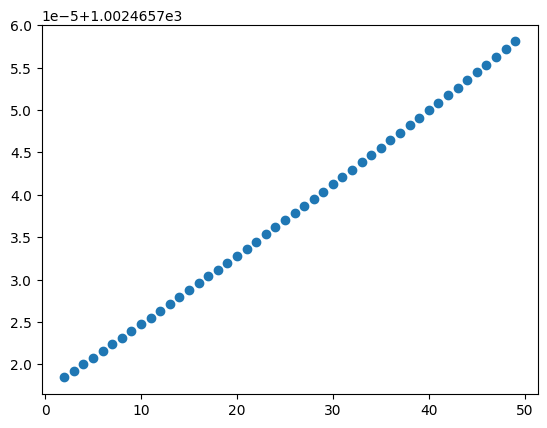

In [133]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter([i for i in range(2, 50)], scores)

In [136]:
pca = PCA(n_components=20)
pca.fit(mtx_mentioners.todense())
scores.append(pca.score(mtx_mentioners.todense()))

In [143]:
for comp in pca.components_:
    res = sorted(
        [(c, n) for c, n in zip(comp, [node for node in co_mentioners.nodes]) if c > 0.0], key=lambda b: b[0], reverse=True)[:20]
    print([r[1] for r in res])
    print(collections.Counter([outlet_to_collection[r[1]] for r in res]))

['viewpointsonline.org', 'rightwingwatch.org', 'rosevilletoday.com', 'mynews13.com', 'dailybreeze.com', 'suntimes.com', 'sdrostra.com', 'northbaybusinessjournal.com', 'advocate-news.com', 'northcoastjournal.com', 'sbstatesman.com', 'nyunews.com', 'legislativegazette.com', 'tribtoday.com', 'cw39.com', 'santaclaritamagazine.com', 'altamontenterprise.com', 'order-order.com', 'myvalleynews.com', 'austinchronicle.com']
Counter({'california': 11, 'newyork': 4, 'texas': 2, 'florida': 1, 'illinois': 1, 'ohio': 1})
['thereporter.com', 'angelusnews.com', 'niagarafallsreporter.com', 'yonkerstribune.com', 'watermarkonline.com', 'jewishworldnews.org', 'advocate-news.com', 'theroundupnews.com', 'theticker.org', 'fox4news.com', 'wptv.com', 'dailytrojan.com', 'tpr.org', 'dailynexus.com', 'clickorlando.com', 'westsidetoday.com', 'northcoastcurrent.com', 'longislandpress.com', 'rbj.net', 'mypanhandle.com']
Counter({'california': 7, 'newyork': 6, 'florida': 4, 'texas': 2, 'illinois': 1})
['sarasotamagazi